In [76]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt

# Utilities and analysis setup

In [77]:
# dict to map node ID to node address
node_map = {
    '1': 'planetlab2.citadel.edu',
    '2': 'planetlab2.c3sl.ufpr.br',
    '3': 'planetlab6.goto.info.waseda.ac.jp',
    '4': 'pl-dccd-01.cua.uam.mx',
    '5': 'planetlab3.rutgers.edu',
    '6': 'planetlab2.ie.cuhk.edu.hk',
    '7': 'planetlab1.temple.edu',
    '8': 'planetlab1.rutgers.edu'
}

node_loc = {
    '1': 'US (Citadel)',
    '2': 'Brazil',
    '3': 'Japan',
    '4': 'Mexico',
    '5': 'US (Rutgers 3)',
    '6': 'Hong Kong',
    '7': 'US (Temple)',
    '8': 'US (Rutgers 1)'
}

node_pairs = {
    '1': '1-2 & 2-1'
}

# dict to map each node's to its respective timezone


### Set the current working directory to the project root

In [78]:
os.chdir("/Users/jlahut/UAlbany/comp-comm-networks/final-project/project/")

### Read in data files
Data files have the following format `<type>_<src>-<dest>_<Y-M-D>_<H-M-S>`  
*The timestamps in the file names are local to the node in which it came from*

In [80]:
data = []
for filename in os.listdir("data/"):
    try:
        items = filename.split('_')

        measure = items[0]
        src, dest = items[1].split('-')

        date = items[2]
        time = items[3].split('.')[0]

        timestamp = dt.datetime.strptime(f'{date} {time}', '%Y-%m-%d %H-%M-%S')
        content = ''

        with open(os.path.join('data', filename), 'r') as file:
            content = file.read()
            
        if (src == '1' and dest == '2') or (src == '2' and dest == '1'):
            pair = '1-2 & 2-1'
        elif (src == '3' and dest == '5') or (src == '5' and dest == '3'):
            pair = '3-5 & 5-3'
        elif (src == '4' and dest == '7') or (src == '7' and dest == '4'):
            pair = '4-7 & 7-4'
        elif (src == '6' and dest == '8') or (src == '8' and dest == '6'):
            pair = '6-8 & 8-6'
        elif (src == '1' and dest == '5') or (src == '5' and dest == '1'):
            pair = '1-5 & 5-1'
        else:
            pair = 'Error'

        data.append([src, dest, timestamp, measure, node_map[src], node_map[dest], content, filename, pair])
    except:
        print(f'Could not read file: {filename}')

Could not read file: traceroute_-_2019-11-21_01-36-28.txt


### Create 'master' dataframe to hold all raw data

In [141]:
df = pd.DataFrame(data, columns = ['src_id', 'dest_id', 'time', 'measure', 'src_name', 'dest_name', 'raw_data', 'filename', 'pair'])

### Ping and Traceroute functions to be applied accross the dataframe
- Used mainly for file parsing


In [142]:
# example format
# rtt min/avg/max/mdev = 68.244/68.337/68.498/0.129 ms or
# rtt min/avg/max/mdev = 68.244/68.337/68.498/0.129 ms, pipe n
# 20 packets transmitted, 20 received, 0% packet loss, time 19029ms
def analyze_ping(data):
    try:
        # --- parse out statistics ---
        # second to last line will always be calculated values
        # split on '=' sign, then strip all spaces, remove units, and finally split on '/'
        # giving the values we need
        metrics = data['raw_data'].split('\n')[-2].split('=')[1].strip().replace(' ms', '').split(',')[0].split('/')
        data['min_ping_time'], data['avg_ping_time'], data['max_ping_time'], data['sd_ping_time'] = \
            float(metrics[0]), float(metrics[1]), float(metrics[2]), float(metrics[3])
        
        # --- parse out packet loss ---
        # third to last line will always be the line with packet loss
        data['packet_loss'] = float(data['raw_data'].split('\n')[-3].split(',')[2].split(' ')[1].replace('%', ''))
    except Exception as e:
        print(f"No calculated data for: {data['filename']}")
    return data

def analyze_traceroute(data):
    # TODO
    return data

### Apply the functions

In [143]:
df = df[df['measure'] == 'ping'].apply(analyze_ping, axis = 1)
# df = df[df['measure'] == 'traceroute'].apply(analyze_traceroute, axis = 1)

No calculated data for: ping_5-3_2019-11-28_20-26-34.txt
No calculated data for: ping_7-4_2019-11-27_03-21-14.txt
No calculated data for: ping_8-6_2019-11-25_18-34-59.txt
No calculated data for: ping_5-3_2019-11-25_18-09-07.txt
No calculated data for: ping_2-1_2019-11-22_20-02-21.txt


### Plotting average ping times for nodes

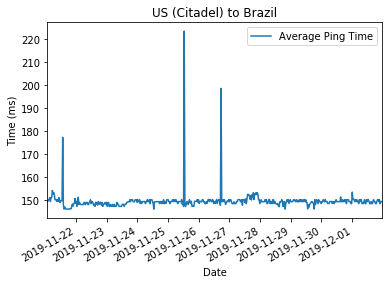

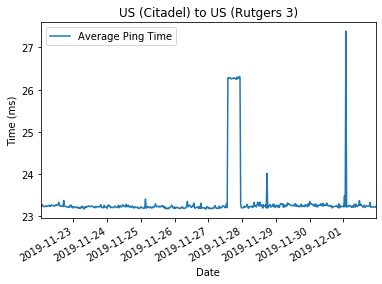

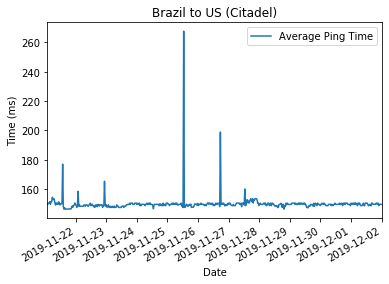

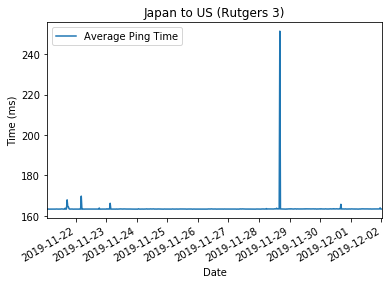

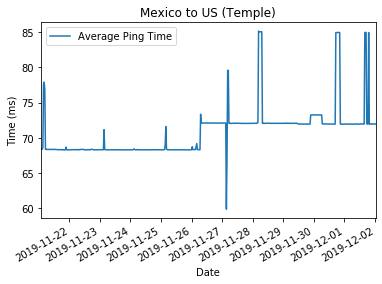

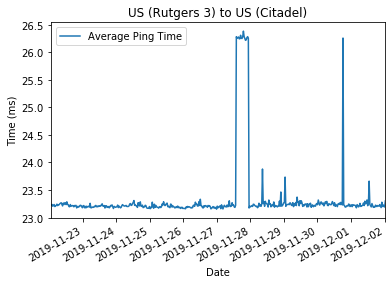

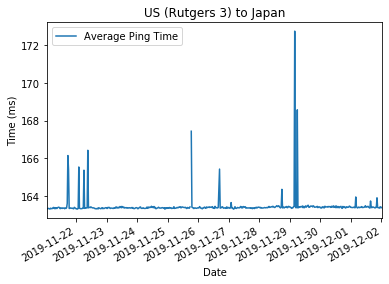

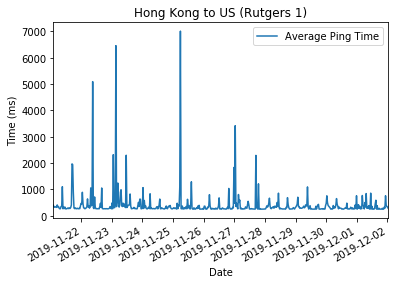

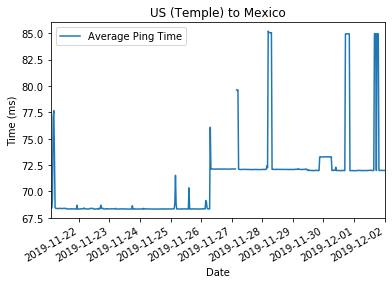

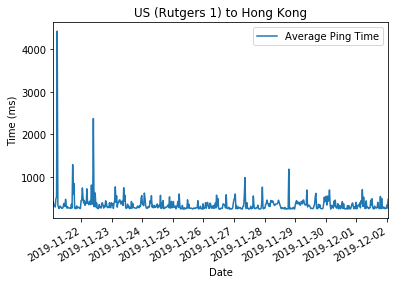

In [144]:
for title, group in df[df['measure'] == 'ping'].groupby(['src_id', 'dest_id']):
    ax = group.plot(x = 'time', y = 'avg_ping_time', title = f'{node_loc[title[0]]} to {node_loc[title[1]]}')
    ax.legend(['Average Ping Time'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Time (ms)')

### High level results of experiment

Ping timing statistics

|                        | US (Citadel) to Brazil | US (Citadel) to US (Rutgers 3) | Japan to US (Rutgers 3) | Mexico to US (Temple) | Hong Kong to US (Rutgers 1) |
| ---------------------- | :--------------------: | :----------------------------: | :---------------------: | :-------------------: | :-------------------------: |
| **Minimum ping time**  |        149.378         |             23.265             |         163.366         |        70.744         |           260.729           |
| **Average ping time**  |        149.634         |             23.353             |         163.529         |        70.842         |           378.509           |
| **Max ping time**      |        150.350         |             23.649             |         164.364         |        71.019         |           784.111           |
| **Standard deviation** |         0.521          |             0.184              |          0.527          |         0.276         |           142.709           |

In [202]:
def calc_gaps(group):
    
    # sort on time, shift column down, subtract the two for gap value
    group = group.assign(gaptime=group.sort_values(
        by=['time'])['time'] - group.sort_values(by=['time']).shift()['time'])
    
    # sort on time, shift column down, add a boolean if it exceeds the threshold
    group = group.assign(gap=group.sort_values(
        by=['time'])['time'] - group.sort_values(by=['time']).shift()['time'] > dt.timedelta(minutes=59))
   
    return group

# calculate the gaps for each node
df = df.groupby(['src_id', 'dest_id']).apply(calc_gaps)
# reset the indicies from the groupby function. columns will be grouped on both 'src_id' and 'dest_id',
# so drop them
df = df.reset_index(level=0, drop=True).reset_index(level=0, drop=True).reset_index().drop(columns=['index'])

# for title, group in df.groupby(['pair']):
    
#     print(f'---- Statistics for {title} ----')
#     print(f"{node_loc[title.split('-')[0]]} to {node_loc[title.split('-')[1].split(' ')[0]]}")
    
#     print(f'Mean minimum ping time: {group["min_ping_time"].describe()["mean"]}')
#     print(f'Mean average ping time: {group["avg_ping_time"].describe()["mean"]}')
#     print(f'Mean max ping time: {group["max_ping_time"].describe()["mean"]}')
#     print(f'Mean sd ping time: {group["sd_ping_time"].describe()["mean"]}')
#     print()

### Calculating pair-wise outages
We define an outage by having a gap larger than the expected time interval, 30 minutes. In other words, if the gap between two files is an hour or more, we know we had an outage.  
There was not an observed gap of longer than an hour, signaling that all outages were only for one given file, or measurement.

In [212]:
for title, group in df[df['gap'] == True].groupby('pair'):
    print(f"---- {node_loc[title.split('-')[0]]} to {node_loc[title.split('-')[1].split(' ')[0]]} ----")
    print(f'Outages for pair: {len(group)}')

---- US (Citadel) to Brazil ----
Outages for pair: 2
---- US (Citadel) to US (Rutgers 3) ----
Outages for pair: 3
---- Japan to US (Rutgers 3) ----
Outages for pair: 2
---- Mexico to US (Temple) ----
Outages for pair: 3
---- Hong Kong to US (Rutgers 1) ----
Outages for pair: 2


### Calculate CDF for packet loss and latency

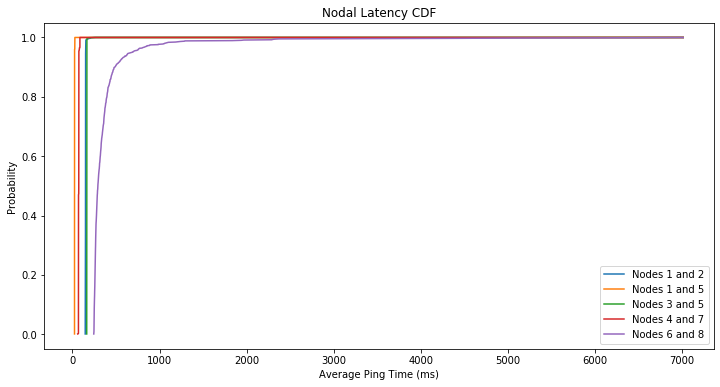

In [213]:
# first group by each src, desc pair
fig, ax = plt.subplots(figsize=(12, 6))
legend = []
for title, group in df[df['measure'] == 'ping'].groupby(['pair']):
    
    # then group by the avg_ping_time
    stats_df = group.groupby('avg_ping_time')['avg_ping_time'].agg('count').pipe(pd.DataFrame).rename(
        columns = {'avg_ping_time': 'frequency'})
    
    # probability that the current time occurs
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
    # cumulative probability
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    
    # add the max value to each plot so that the CDF lines continue to end
    plt.plot(stats_df['avg_ping_time'].tolist()+[df['avg_ping_time'].max()],stats_df['cdf'].tolist()+[1])
    
    if '1-2' in title:
        legend.append('Nodes 1 and 2')
    elif '1-5' in title:
        legend.append('Nodes 1 and 5')
    elif '3-5' in title:
        legend.append('Nodes 3 and 5')
    elif '4-7' in title:
        legend.append('Nodes 4 and 7')
    elif '6-8' in title:
        legend.append('Nodes 6 and 8')
    ax.legend(legend)
    ax.set_title('Nodal Latency CDF')
    ax.set_xlabel('Average Ping Time (ms)')
    ax.set_ylabel('Probability')

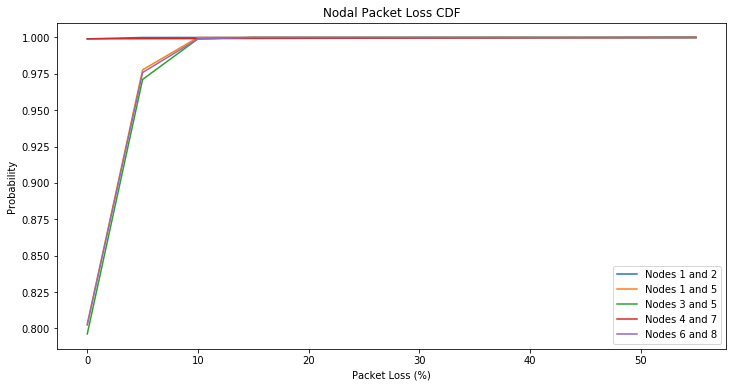

In [214]:
# first group by each src, desc pair
fig, ax = plt.subplots(figsize=(12, 6))
legend = []
for title, group in df[df['measure'] == 'ping'].groupby(['pair']):
    
    # then group by the avg_ping_time
    stats_df = group.groupby('packet_loss')['packet_loss'].agg('count').pipe(pd.DataFrame).rename(
        columns = {'packet_loss': 'frequency'})
    
    # probability that the current time occurs
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
    # cumulative probability
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    
    # add the max value to each plot so that the CDF lines continue to end
    plt.plot(stats_df['packet_loss'].tolist()+[df['packet_loss'].max()],stats_df['cdf'].tolist()+[1])
    
    if '1-2' in title:
        legend.append('Nodes 1 and 2')
    elif '1-5' in title:
        legend.append('Nodes 1 and 5')
    elif '3-5' in title:
        legend.append('Nodes 3 and 5')
    elif '4-7' in title:
        legend.append('Nodes 4 and 7')
    elif '6-8' in title:
        legend.append('Nodes 6 and 8')
    ax.legend(legend)
    ax.set_title('Nodal Packet Loss CDF')
    ax.set_xlabel('Packet Loss (%)')
    ax.set_ylabel('Probability')